1.Logistic Regression

Libraries

In [185]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



Data Loading

In [153]:
transform = transforms.Compose([
    transforms.ToTensor(),  # convert image to PyTorch tensor
    transforms.Normalize((0.0,), (1.0,))  # normalize to [0,1]
])

mnist_train = datasets.MNIST(root='data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='data', train=False, transform=transform, download=True)


In [154]:
print(f"Number of training samples: {len(mnist_train)}")

Number of training samples: 60000


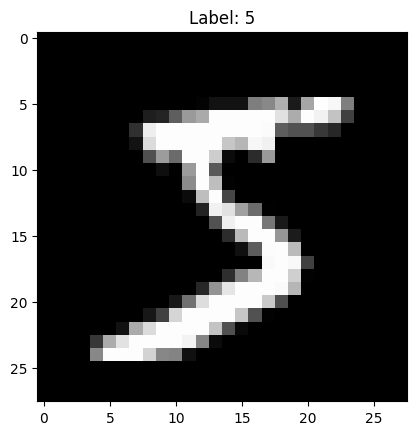

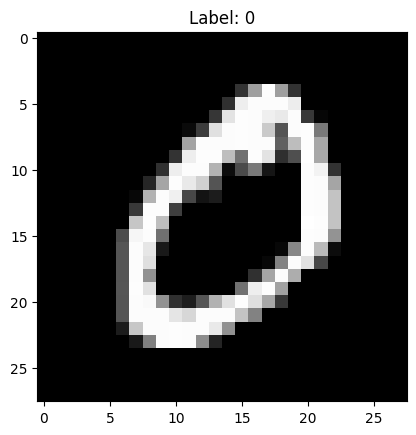

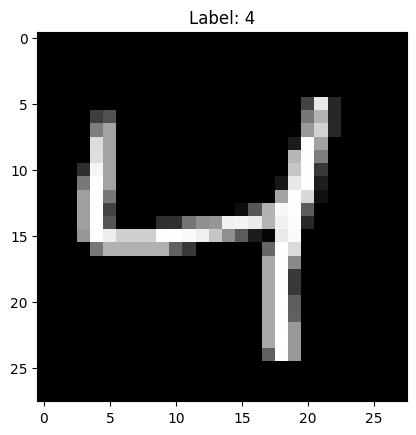

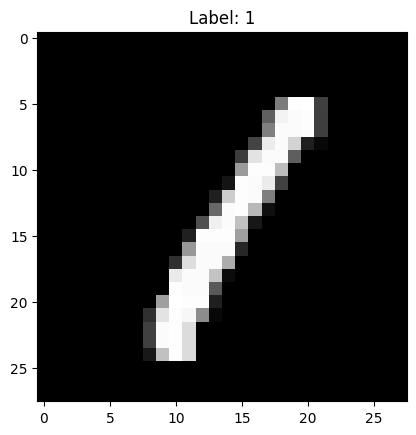

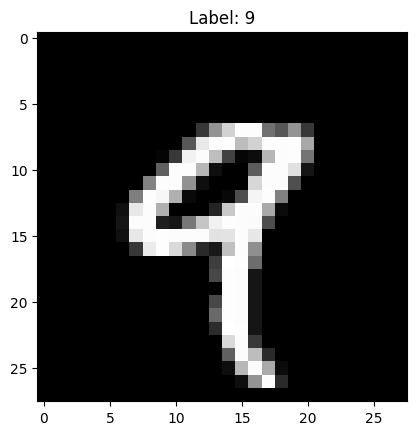

In [155]:

for i in range(5):
    image, label = mnist_train[i]
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()


In [156]:
X = []
y = []

for img, label in mnist_train:
    if label in [0, 1]:
        X.append(img.view(-1))  # flatten 28x28 -> 784
        y.append(label)

X = torch.stack(X)
y = torch.tensor(y)


In [157]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)
print(f"Train size: {X_train.shape[0]}, Val size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 7599, Val size: 2533, Test size: 2533


In [158]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

In [159]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))


In [160]:
def binary_cross_entropy(y_hat, y):
    eps = 1e-15
    y_hat = torch.clamp(y_hat, eps, 1 - eps) # prevent log(0)
    #y_hat < eps = eps
    #y_hat > 1 - eps = 1 - eps
    return -torch.mean(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))


In [161]:
# Number of features = 784 pixels per image
n_features = 784

# Initialize weights and bias
W = torch.zeros((n_features, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [ ]:
# --- Hyperparameters and trackers ---
learning_rate = 0.01
epochs = 100
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

# --- Training loop ---
for epoch in range(epochs):
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    # ----- TRAINING PHASE -----
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = sigmoid(X_batch @ W + b)
        loss = binary_cross_entropy(y_pred, y_batch.unsqueeze(1).float())

        # Backward pass
        loss.backward()

        # Gradient update (manual SGD)
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # Reset gradients
        W.grad.zero_()
        b.grad.zero_()

        # Accumulate batch loss
        epoch_loss += loss.item()
        # Compute training accuracy per batch
        preds = (y_pred > 0.5).int().squeeze()
        correct_train += (preds == y_batch).sum().item()
        total_train += y_batch.size(0)        

    # Compute average training loss for this epoch
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(correct_train / total_train)

    # ----- VALIDATION PHASE -----
    with torch.no_grad():
        val_loss_total = 0.0
        correct = 0
        total = 0

        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = sigmoid(X_val_batch @ W + b)
            val_loss_total += binary_cross_entropy(y_val_pred, y_val_batch.unsqueeze(1).float()).item()

            # Compute accuracy
            y_val_pred_label = (y_val_pred > 0.5).int().squeeze()
            correct += (y_val_pred_label == y_val_batch).sum().item()
            total += y_val_batch.size(0)

        avg_val_loss = val_loss_total / len(val_loader)
        val_acc = correct / total

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

    # Print progress for this epoch
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_accuracies[-1]:.4f} | "
          f"Val Acc: {val_accuracies[-1]:.4f}")

Epoch 1/100 | Train Loss: 0.2322 | Val Loss: 0.1062 | Train Acc: 0.9916 | Val Acc: 0.9945
Epoch 2/100 | Train Loss: 0.0789 | Val Loss: 0.0632 | Train Acc: 0.9970 | Val Acc: 0.9949
Epoch 3/100 | Train Loss: 0.0525 | Val Loss: 0.0473 | Train Acc: 0.9971 | Val Acc: 0.9953
Epoch 4/100 | Train Loss: 0.0407 | Val Loss: 0.0389 | Train Acc: 0.9974 | Val Acc: 0.9957
Epoch 5/100 | Train Loss: 0.0339 | Val Loss: 0.0336 | Train Acc: 0.9975 | Val Acc: 0.9961
Epoch 6/100 | Train Loss: 0.0295 | Val Loss: 0.0299 | Train Acc: 0.9975 | Val Acc: 0.9961
Epoch 7/100 | Train Loss: 0.0263 | Val Loss: 0.0271 | Train Acc: 0.9978 | Val Acc: 0.9964
Epoch 8/100 | Train Loss: 0.0239 | Val Loss: 0.0250 | Train Acc: 0.9978 | Val Acc: 0.9964
Epoch 9/100 | Train Loss: 0.0220 | Val Loss: 0.0234 | Train Acc: 0.9978 | Val Acc: 0.9964
Epoch 10/100 | Train Loss: 0.0205 | Val Loss: 0.0220 | Train Acc: 0.9978 | Val Acc: 0.9964
Epoch 11/100 | Train Loss: 0.0193 | Val Loss: 0.0208 | Train Acc: 0.9979 | Val Acc: 0.9964
Epoch 12

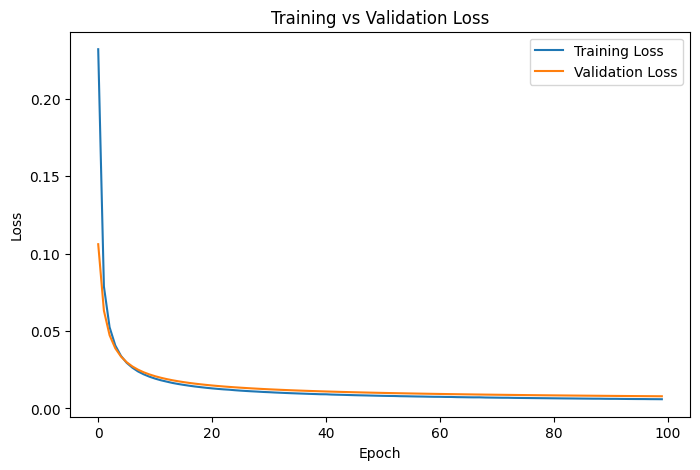

In [163]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


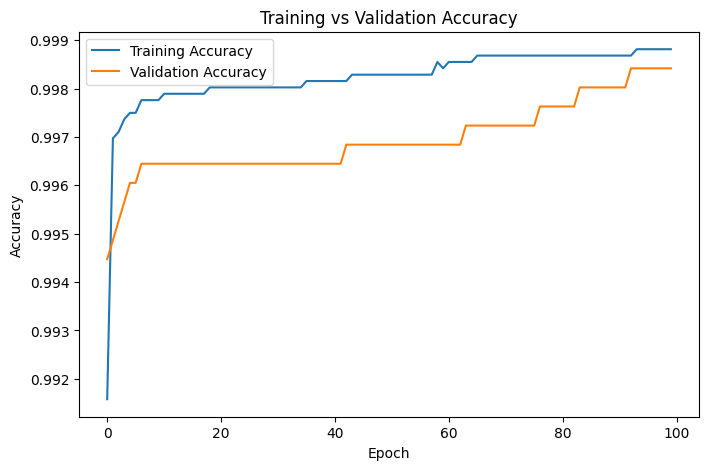

In [164]:
plt.figure(figsize=(8,5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

Test Accuracy: 0.9984


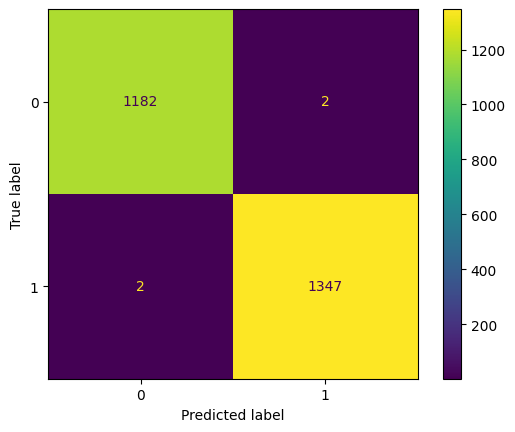

In [165]:
with torch.no_grad():
    y_test_pred = sigmoid(X_test @ W + b)
    y_test_pred_label = (y_test_pred > 0.5).int().squeeze()

test_acc = (y_test_pred_label == y_test).float().mean()
print(f"Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_test, y_test_pred_label)
ConfusionMatrixDisplay(cm).plot()
plt.show()


In [166]:
model_sklearn = LogisticRegression(max_iter=100, solver='liblinear')
model_sklearn.fit(X_train, y_train)

train_acc_sklearn = model_sklearn.score(X_train, y_train)
val_acc_sklearn = model_sklearn.score(X_val, y_val)
test_acc_sklearn = model_sklearn.score(X_test, y_test)

print(f"Sklearn Logistic Regression - Training Accuracy: {train_acc_sklearn:.4f}")
print(f"Sklearn Logistic Regression - Validation Accuracy: {val_acc_sklearn:.4f}")
print(f"Sklearn Logistic Regression - Test Accuracy: {test_acc_sklearn:.4f}")


Sklearn Logistic Regression - Training Accuracy: 1.0000
Sklearn Logistic Regression - Validation Accuracy: 0.9988
Sklearn Logistic Regression - Test Accuracy: 0.9988


In [167]:
manual_final_train_acc = train_accuracies[-1]
manual_final_val_acc = val_accuracies[-1]



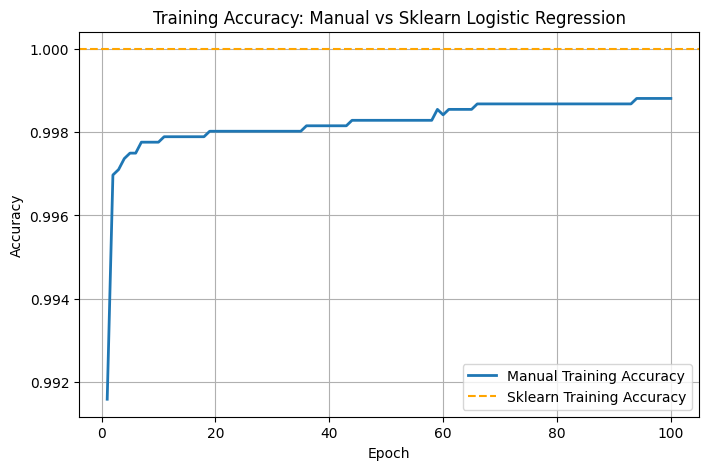

In [168]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Manual Training Accuracy', linewidth=2)
plt.axhline(y=train_acc_sklearn, color='orange', linestyle='--', label='Sklearn Training Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy: Manual vs Sklearn Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

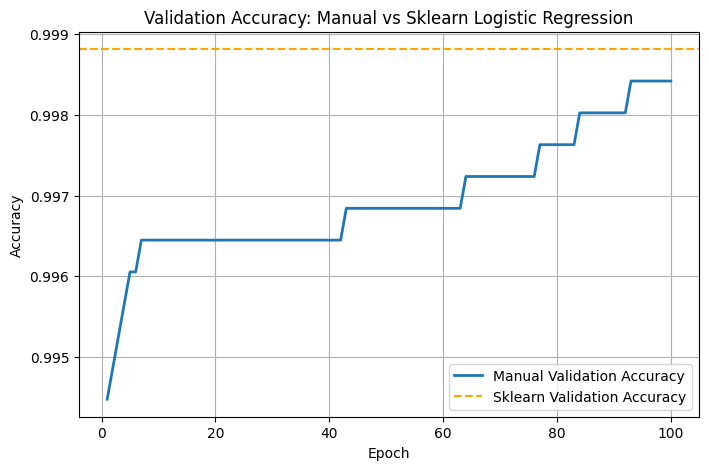

In [169]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Manual Validation Accuracy', linewidth=2)
plt.axhline(y=val_acc_sklearn, color='orange', linestyle='--', label='Sklearn Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy: Manual vs Sklearn Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

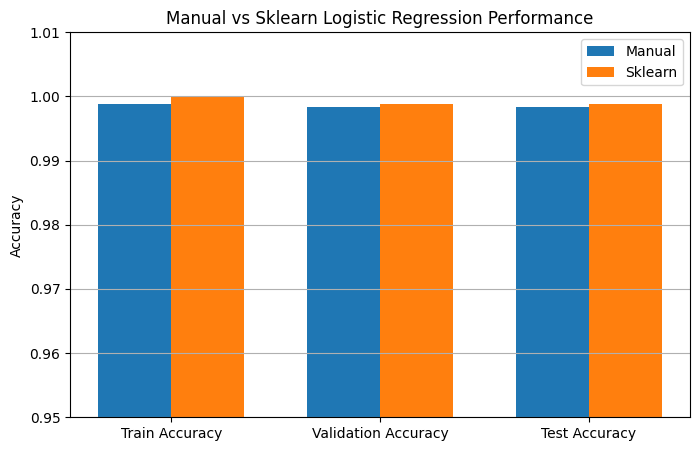

In [170]:
labels = ['Train Accuracy', 'Validation Accuracy', 'Test Accuracy']
manual_values = [
    manual_final_train_acc,
    manual_final_val_acc,
    (y_test_pred_label == y_test).float().mean().item()
]
sklearn_values = [
    train_acc_sklearn,
    val_acc_sklearn,
    model_sklearn.score(X_test, y_test)
]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, manual_values, width, label='Manual')
plt.bar(x + width/2, sklearn_values, width, label='Sklearn')
plt.ylabel('Accuracy')
plt.title('Manual vs Sklearn Logistic Regression Performance')
plt.xticks(x, labels)
plt.ylim(0.95, 1.01)
plt.legend()
plt.grid(axis='y')
plt.show()

In [189]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='data', train=True, transform=transform, download=True)

In [190]:
# Filter digits 0 and 1
X = []
y = []
for img, label in mnist_train:
    if label in [0, 1]:
        X.append(img.view(-1))
        y.append(label)

X = torch.stack(X)
y = torch.tensor(y, dtype=torch.float32) 

In [193]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)
print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Train set size: 7599
Validation set size: 2533
Test set size: 2533


In [194]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=64)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

In [186]:
model = nn.Linear(784, 1)


In [187]:
criterion = nn.BCEWithLogitsLoss()       # combines sigmoid + BCE for stability
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [197]:
epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # TRAIN
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).int()
        correct_train += (preds == y_batch.int()).sum().item()
        total_train += y_batch.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            outputs_val = model(X_val_batch).squeeze()
            loss = criterion(outputs_val, y_val_batch)
            val_loss += loss.item()

            preds_val = (torch.sigmoid(outputs_val) > 0.5).int()
            correct_val += (preds_val == y_val_batch.int()).sum().item()
            total_val += y_val_batch.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/100 | Train Loss: 0.0046 | Val Loss: 0.0047 | Train Acc: 0.9989 | Val Acc: 0.9988
Epoch 2/100 | Train Loss: 0.0046 | Val Loss: 0.0047 | Train Acc: 0.9989 | Val Acc: 0.9988
Epoch 3/100 | Train Loss: 0.0046 | Val Loss: 0.0047 | Train Acc: 0.9989 | Val Acc: 0.9988
Epoch 4/100 | Train Loss: 0.0046 | Val Loss: 0.0047 | Train Acc: 0.9989 | Val Acc: 0.9988
Epoch 5/100 | Train Loss: 0.0046 | Val Loss: 0.0046 | Train Acc: 0.9989 | Val Acc: 0.9988
Epoch 6/100 | Train Loss: 0.0045 | Val Loss: 0.0046 | Train Acc: 0.9989 | Val Acc: 0.9988
Epoch 7/100 | Train Loss: 0.0045 | Val Loss: 0.0046 | Train Acc: 0.9989 | Val Acc: 0.9988
Epoch 8/100 | Train Loss: 0.0045 | Val Loss: 0.0046 | Train Acc: 0.9989 | Val Acc: 0.9988
Epoch 9/100 | Train Loss: 0.0045 | Val Loss: 0.0046 | Train Acc: 0.9989 | Val Acc: 0.9988
Epoch 10/100 | Train Loss: 0.0045 | Val Loss: 0.0046 | Train Acc: 0.9989 | Val Acc: 0.9988
Epoch 11/100 | Train Loss: 0.0045 | Val Loss: 0.0046 | Train Acc: 0.9989 | Val Acc: 0.9988
Epoch 12

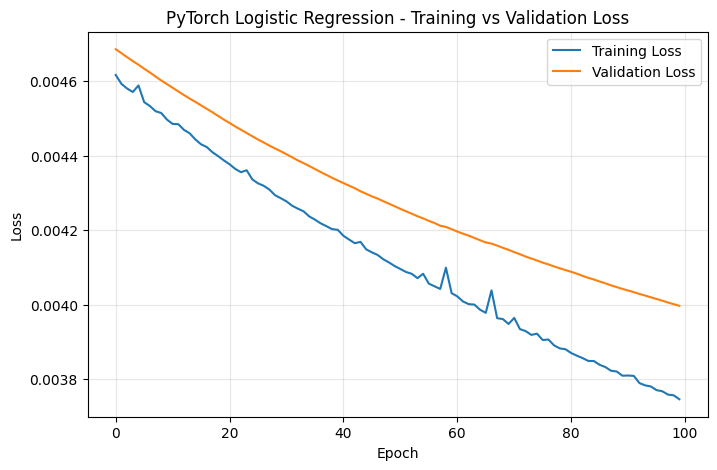

In [199]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PyTorch Logistic Regression - Training vs Validation Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# transform = transforms.Compose([
#     transforms.ToTensor()  # Convert to tensor and scale to [0,1]
# ])

In [ ]:
# def softmax(z):
#     exp_z = torch.exp(z - torch.max(z, dim=1, keepdim=True).values)
#     return exp_z / exp_z.sum(dim=1, keepdim=True)

In [ ]:
# def cross_entropy_loss(y_hat, y_true):
#     eps = 1e-15
#     y_hat = torch.clamp(y_hat, eps, 1 - eps)
#     one_hot = torch.nn.functional.one_hot(y_true, num_classes=10).float()
#     return -torch.mean(torch.sum(one_hot * torch.log(y_hat), dim=1))

In [ ]:
# n_classes = 10
# W_softmax = torch.zeros((n_features, n_classes), requires_grad=True)
# b_softmax = torch.zeros(n_classes, requires_grad=True)

In [ ]:
# learning_rate = 0.01
# epochs = 100
# train_losses_softmax = []
# val_losses_softmax = []
# val_accuracies_softmax = []
# train_accuracies_softmax = []

# # --- Training loop ---
# for epoch in range(epochs):
#     epoch_loss = 0.0
#     correct_train = 0
#     total_train = 0

#     # ----- TRAINING PHASE -----
#     for X_batch, y_batch in train_loader:
#         # Forward pass
#         y_pred = softmax(X_batch @ W + b)
#         loss = cross_entropy_loss(y_pred, y_batch)

#         # Backward pass
#         loss.backward()

#         # Gradient update (manual SGD)
#         with torch.no_grad():
#             W -= learning_rate * W.grad
#             b -= learning_rate * b.grad

#         # Reset gradients
#         W.grad.zero_()
#         b.grad.zero_()


#         # Accumulate batch loss
#         epoch_loss += loss.item()
#         # Compute training accuracy per batch
#         preds = y_pred.argmax(dim=1)
#         correct_train += (preds == y_batch).sum().item()
#         total_train += y_batch.size(0)        

#     # Compute average training loss for this epoch
#     avg_train_loss = epoch_loss / len(train_loader)
#     train_losses_softmax.append(avg_train_loss)
#     train_accuracies_softmax.append(correct_train / total_train)

#     # ----- VALIDATION PHASE -----
#     with torch.no_grad():
#         val_loss_total = 0.0
#         correct = 0
#         total = 0

#         for X_val_batch, y_val_batch in val_loader:
#             y_val_pred = softmax(X_val_batch @ W + b)
#             val_loss_total += cross_entropy_loss(y_val_pred, y_val_batch).item()

#             # Compute accuracy
#             y_val_pred_label = y_val_pred.argmax(dim=1)
#             correct += (y_val_pred_label == y_val_batch).sum().item()
#             total += y_val_batch.size(0)

#         avg_val_loss = val_loss_total / len(val_loader)
#         val_acc = correct / total

#         val_losses_softmax.append(avg_val_loss)
#         val_accuracies_softmax.append(val_acc)

#     # Print progress for this epoch
#     print(f"Epoch {epoch+1}/{epochs} | "
#           f"Train Loss: {avg_train_loss:.4f} | "
#           f"Val Loss: {avg_val_loss:.4f} | "
#           f"Train Acc: {train_accuracies_softmax[-1]:.4f} | "
#           f"Val Acc: {val_accuracies_softmax[-1]:.4f}")

Epoch 1/100 | Train Loss: 0.0000 | Val Loss: 0.0000 | Train Acc: 0.4677 | Val Acc: 0.4678
Epoch 2/100 | Train Loss: 0.0000 | Val Loss: 0.0000 | Train Acc: 0.4677 | Val Acc: 0.4678
Epoch 3/100 | Train Loss: 0.0000 | Val Loss: 0.0000 | Train Acc: 0.4677 | Val Acc: 0.4678
Epoch 4/100 | Train Loss: 0.0000 | Val Loss: 0.0000 | Train Acc: 0.4677 | Val Acc: 0.4678
Epoch 5/100 | Train Loss: 0.0000 | Val Loss: 0.0000 | Train Acc: 0.4677 | Val Acc: 0.4678
Epoch 6/100 | Train Loss: 0.0000 | Val Loss: 0.0000 | Train Acc: 0.4677 | Val Acc: 0.4678
Epoch 7/100 | Train Loss: 0.0000 | Val Loss: 0.0000 | Train Acc: 0.4677 | Val Acc: 0.4678
Epoch 8/100 | Train Loss: 0.0000 | Val Loss: 0.0000 | Train Acc: 0.4677 | Val Acc: 0.4678
Epoch 9/100 | Train Loss: 0.0000 | Val Loss: 0.0000 | Train Acc: 0.4677 | Val Acc: 0.4678
Epoch 10/100 | Train Loss: 0.0000 | Val Loss: 0.0000 | Train Acc: 0.4677 | Val Acc: 0.4678
Epoch 11/100 | Train Loss: 0.0000 | Val Loss: 0.0000 | Train Acc: 0.4677 | Val Acc: 0.4678
Epoch 12

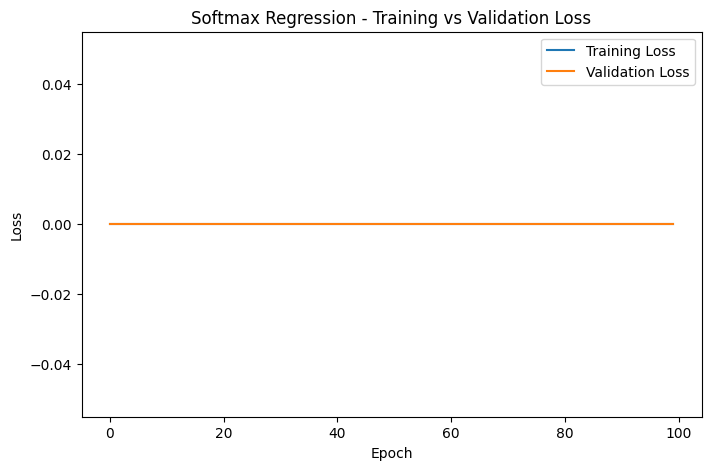

In [ ]:
# plt.figure(figsize=(8,5))
# plt.plot(train_losses_softmax, label='Training Loss')
# plt.plot(val_losses_softmax, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Softmax Regression - Training vs Validation Loss')
# plt.legend()
# plt.show()

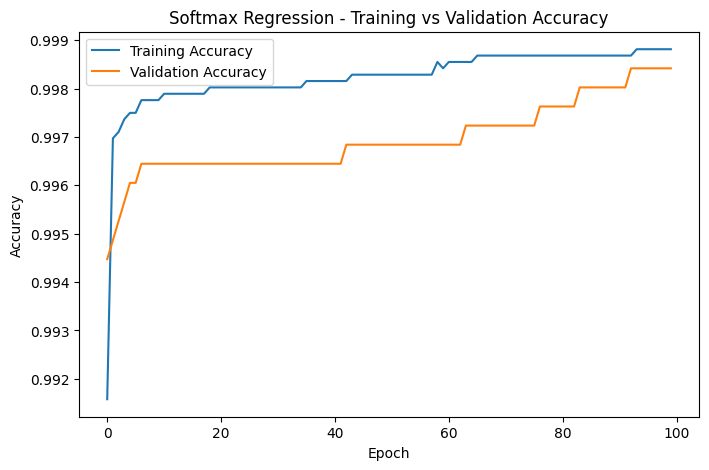

In [ ]:
# plt.figure(figsize=(8,5))
# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(val_accuracies, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Softmax Regression - Training vs Validation Accuracy')
# plt.legend()
# plt.show()

Final Test Accuracy: 0.4674


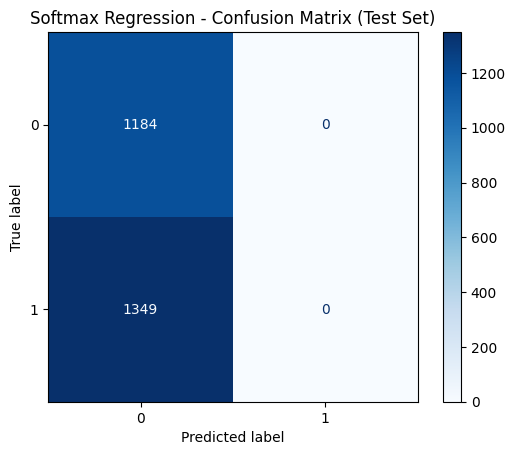

In [ ]:
# with torch.no_grad():
#     logits_test = X_test @ W + b
#     y_test_pred = softmax(logits_test)
#     y_test_pred_label = y_test_pred.argmax(dim=1)

# test_acc = (y_test_pred_label == y_test).float().mean().item()
# print(f"Final Test Accuracy: {test_acc:.4f}")

# cm = confusion_matrix(y_test, y_test_pred_label)
# ConfusionMatrixDisplay(cm).plot(cmap='Blues')
# plt.title("Softmax Regression - Confusion Matrix (Test Set)")
# plt.show()

In [ ]:
# model_sklearn_softmax = LogisticRegression(max_iter=100, solver='lbfgs', multi_class='multinomial')
# model_sklearn_softmax.fit(X_train, y_train)

# train_acc_sklearn_softmax = model_sklearn_softmax.score(X_train, y_train)
# val_acc_sklearn_softmax = model_sklearn_softmax.score(X_val, y_val)
# test_acc_sklearn_softmax = model_sklearn_softmax.score(X_test, y_test)

# print(f"Sklearn Logistic Regression - Training Accuracy: {train_acc_sklearn_softmax:.4f}")
# print(f"Sklearn Logistic Regression - Validation Accuracy: {val_acc_sklearn_softmax:.4f}")
# print(f"Sklearn Logistic Regression - Test Accuracy: {test_acc_sklearn_softmax:.4f}")


c:\Users\mirol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Sklearn Logistic Regression - Training Accuracy: 1.0000
Sklearn Logistic Regression - Validation Accuracy: 0.9988
Sklearn Logistic Regression - Test Accuracy: 0.9984


In [ ]:
# manual_final_train_acc_softmax = train_accuracies_softmax[-1]
# manual_final_val_acc_softmax = val_accuracies_softmax[-1]



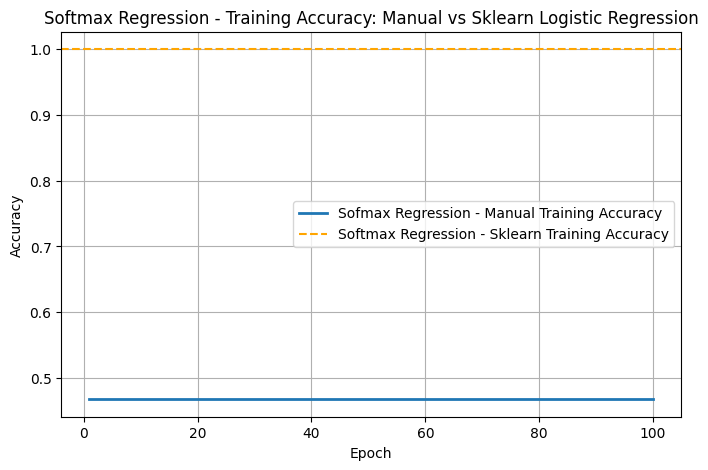

In [ ]:
# plt.figure(figsize=(8,5))
# plt.plot(range(1, len(train_accuracies_softmax)+1), train_accuracies_softmax, label='Sofmax Regression - Manual Training Accuracy', linewidth=2)
# plt.axhline(y=train_acc_sklearn_softmax, color='orange', linestyle='--', label='Softmax Regression - Sklearn Training Accuracy')

# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Softmax Regression - Training Accuracy: Manual vs Sklearn Logistic Regression')
# plt.legend()
# plt.grid(True)
# plt.show()

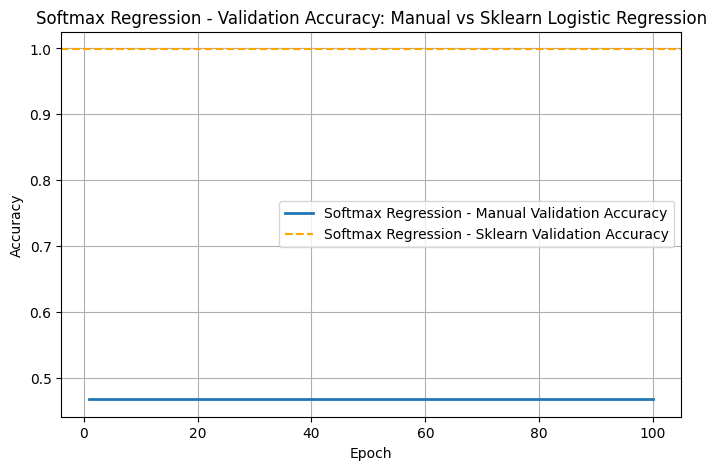

In [ ]:
# plt.figure(figsize=(8,5))
# plt.plot(range(1, len(val_accuracies_softmax)+1), val_accuracies_softmax, label='Softmax Regression - Manual Validation Accuracy', linewidth=2)
# plt.axhline(y=val_acc_sklearn_softmax, color='orange', linestyle='--', label='Softmax Regression - Sklearn Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Softmax Regression - Validation Accuracy: Manual vs Sklearn Logistic Regression')
# plt.legend()
# plt.grid(True)
# plt.show()

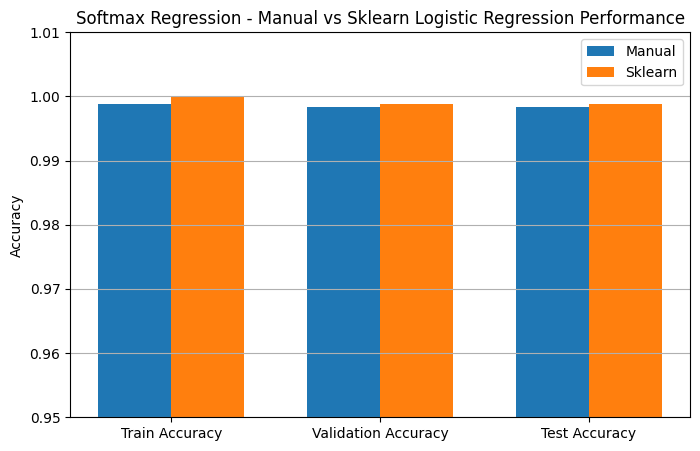

In [ ]:
# labels = ['Train Accuracy', 'Validation Accuracy', 'Test Accuracy']
# manual_values_softmax = [
#     manual_final_train_acc_softmax,
#     manual_final_val_acc_softmax,
#     (y_test_pred_label == y_test).float().mean().item()
# ]
# sklearn_values_softmax = [
#     train_acc_sklearn_softmax,
#     val_acc_sklearn_softmax,
#     model_sklearn_softmax.score(X_test, y_test)
# ]

# x = np.arange(len(labels))
# width = 0.35

# plt.figure(figsize=(8,5))
# plt.bar(x - width/2, manual_values, width, label='Manual')
# plt.bar(x + width/2, sklearn_values, width, label='Sklearn')
# plt.ylabel('Accuracy')
# plt.title('Softmax Regression - Manual vs Sklearn Logistic Regression Performance')
# plt.xticks(x, labels)
# plt.ylim(0.95, 1.01)
# plt.legend()
# plt.grid(axis='y')
# plt.show()